## Generate Invoice Embeddings
To generate the invoice embeddings run the Starspace model on the pre-processed input file that lists the invoices associated with each user. This is the output of the notebook preprocessing_model_1_retail. 
<img src = gen_embeddings.png style="height:60%;">

## Create a Lookup to Retrieve Representation for a Given Invoice

In [6]:
import os
import dask.dataframe as dd
import pandas as pd
os.chdir("/home/admin123/Starspace/")
fp = "/home/admin123/Starspace/"+ "data/pagespace.tsv"
df = pd.read_csv(fp, sep = "\t", header = None)

### Implementation Notes:
The generated invoice embeddings are 100 columns long for each invoice. The first column in the datafile is the invoice and the other 100 columns are the latent representation. So we first setup the column names accordingly in the pandas dataframe. Note that the separator has to be a tab and the header should be set to None (no headers in the generated file). The following lines set up the header for the generated invoice embedding file

In [7]:
rep_cols = ["lcol_" + str(i+1) for i in range(100)]
cols = ["itemcode"] + rep_cols
df.columns = cols

### Implementation Notes:
Create a lookup in the form of a python dictionary with the Invoice as key and the representation for the invoice as a 100 element long list. Note the use of the transpose. This is required.

In [8]:
item_dict = df.set_index("itemcode").T.to_dict('list')
del df

### Determine Invoices For Each Customer

In [13]:
fp = "/home/admin123/Starspace/"+ "data/Online_Retail.csv"
df = pd.read_csv(fp)
df = df[-df['InvoiceNo'].str.startswith("C")]
df = df[-df['StockCode'].str.startswith("BANK")]
#req_cols = ["CustomerID", "InvoiceNo", "StockCode"]
#df = df[req_cols]
df = df.dropna()
df["CustomerID"] = df["CustomerID"].astype(int)
fpp = "/home/admin123/Starspace/data/Online_Retail_CustInvoices.txt"
prefix = "itemcode_"
customer_items = dict()
sep = ","
od1 = dict(tuple(df.groupby(["CustomerID"])))
for customer in od1.keys():
    df_cust_items = od1[(customer)]
    cust_items = df_cust_items["StockCode"].unique().tolist()
    cust_items = [prefix + inv for inv in cust_items]
    customer_items[customer] = cust_items

In [16]:
df["ItemTotal"] = df["UnitPrice"] * df["Quantity"]
df_inv_summary = df.groupby(["CustomerID","InvoiceNo"]).\
agg({'ItemTotal': ['sum'], 'Quantity':['sum'], 'StockCode':['count']}).reset_index()
df_inv_summary.columns = [''.join(col).strip() for col in df_inv_summary.columns]

df_freq_cust = df_inv_summary.groupby('CustomerID').\
agg({'ItemTotalsum': ['sum'], 'InvoiceNo':['count']}).reset_index()

In [21]:
df_freq_cust.columns = ["CustomerID", "InvoiceCount", "AmountSpent"]
df_freq_cust.head()

,CustomerID,InvoiceCount,AmountSpent
0,12346,1,77183.60
1,12347,7,4310.00
2,12348,4,1797.24
3,12349,1,1757.55
4,12350,1,334.40


### Determine User Representation
The representation of a user is the average of his or her invoices.

In [26]:
lu_cust_visit = df_freq_cust[["CustomerID", "InvoiceCount"]].set_index('CustomerID').T.to_dict('series')
lu_cust_spend = df_freq_cust[["CustomerID", "AmountSpent"]].set_index('CustomerID').T.to_dict('series')

In [27]:
lu_cust_visit.keys()

[16384,
 16385,
 16386,
 16387,
 16389,
 16392,
 16393,
 16394,
 16395,
 16398,
 16399,
 16400,
 16401,
 16402,
 16403,
 16404,
 16405,
 16406,
 16407,
 16409,
 16411,
 16412,
 16413,
 16414,
 16415,
 16416,
 16418,
 16419,
 16422,
 16423,
 16424,
 16425,
 16426,
 16427,
 16429,
 16430,
 16431,
 16432,
 16433,
 16434,
 16438,
 16440,
 16441,
 16442,
 16444,
 16445,
 16446,
 16447,
 16448,
 16449,
 16450,
 16451,
 16454,
 16455,
 16456,
 16457,
 16458,
 16460,
 16461,
 16462,
 16463,
 16464,
 16466,
 16468,
 16469,
 16470,
 16471,
 16473,
 16474,
 16475,
 16477,
 16478,
 16479,
 16480,
 16482,
 16483,
 16484,
 16485,
 16488,
 16491,
 16493,
 16494,
 16495,
 16496,
 16497,
 16498,
 16499,
 16500,
 16503,
 16504,
 16505,
 16506,
 16509,
 16510,
 16511,
 16513,
 16515,
 16516,
 16517,
 16518,
 16519,
 16520,
 16523,
 16525,
 16526,
 16527,
 16528,
 16529,
 16531,
 16532,
 16533,
 16535,
 16536,
 16539,
 16542,
 16545,
 16546,
 16549,
 16550,
 16551,
 16552,
 16553,
 16554,
 16555,
 16556,


In [28]:
import numpy as np
cust_rep = dict()
for cust in customer_items:
    inv_list = customer_items[cust]
    inv_as_list_np_arr = [item_dict[i] for i in inv_list]
    inv_as_np_arr = np.array(inv_as_list_np_arr)
    avg_rep = np.mean(inv_as_np_arr, axis = 0)
    avg_rep = np.append(avg_rep, lu_cust_visit[cust])
    avg_rep = np.append(avg_rep, lu_cust_spend[cust])
    cust_rep[cust] = avg_rep     

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
dfc = pd.DataFrame(cust_rep.values())

In [31]:
dfc["Customer"] = cust_rep.keys()

In [33]:
rep_cols = ["lcol_" + str(i+1) for i in range(102)]
cols = rep_cols + ["Customer"]
dfc.columns = cols

### Visualize the Customer Embeddings Using tSNE

In [34]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

### Implementation Notes:
The following embedding can take about 5-7 minutes to run, so please be patient.

In [35]:
X_2d = tsne.fit_transform(dfc[rep_cols].as_matrix())

/home/admin123/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


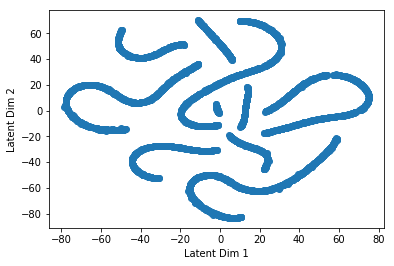

In [36]:
%matplotlib inline
plt.scatter(X_2d[:, 0], X_2d[:, 1])
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.show()

### Observations
Clearly the dataset shows a complex clustering patter. Two concentric clusters are seen. This suggests two user segments. So perhaps clustering the embeddings with a kernel k-means algorithm is appropriate. To gain insight, we must cluster the dataset with an appropriate clustering algorithm and then profile the clusters.

In [39]:
os.chdir("/home/admin123/Starspace/")
fpc = "/home/admin123/Starspace/"+ "data/customer_rep.csv"
dfc.to_csv(fpc, index = False)

In [37]:
dfc.head()

,lcol_1,lcol_2,lcol_3,lcol_4,lcol_5,lcol_6,lcol_7,lcol_8,lcol_9,lcol_10,...,lcol_94,lcol_95,lcol_96,lcol_97,lcol_98,lcol_99,lcol_100,lcol_101,lcol_102,Customer
0,0.006207,-0.010461,0.003782,-0.003536,-0.009066,0.000214,-0.003928,0.001535,0.005195,-0.001614,...,-0.005508,-0.004601,0.000400,0.004732,-0.003386,-0.002999,0.009700,2.0,584.50,16384
1,-0.001737,-0.002224,-0.003980,0.002041,0.002156,0.002901,0.003212,0.000130,0.000395,0.003511,...,-0.001691,-0.000076,-0.007119,-0.005107,0.004490,0.002079,-0.008748,3.0,555.89,16385
2,-0.000802,0.005518,0.000127,-0.001518,0.000134,-0.004479,-0.004880,0.006123,-0.006633,-0.001231,...,-0.001346,-0.001567,-0.002435,-0.000735,-0.003391,-0.003053,-0.004107,2.0,317.20,16386
3,-0.005391,0.015644,-0.004082,-0.003939,-0.008420,0.011472,0.004777,-0.008016,-0.004426,-0.002977,...,-0.000977,-0.001947,0.006017,0.001629,0.000297,-0.001326,0.008040,1.0,94.36,16387
4,-0.001008,-0.000639,0.007787,0.007223,-0.005374,-0.002158,-0.005113,-0.000930,0.003693,0.000047,...,-0.001022,-0.003962,-0.005251,0.000252,0.002528,-0.000787,0.003751,4.0,1382.07,16389
